In [39]:
import numpy as np
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Activation functions:

In [42]:
def relu(x):
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(float)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    x_stable = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x_stable)
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0, 1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1 per sample"
    return result

### MultiClassNeuralNetwork class with Adam optimizer:

In [28]:
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.001, l2_lambda=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert isinstance(l2_lambda, (int, float)) and l2_lambda >= 0, "L2 regularization parameter must be non-negative"
        assert isinstance(beta1, (int, float)) and 0 <= beta1 < 1, "Beta1 must be in [0, 1)"
        assert isinstance(beta2, (int, float)) and 0 <= beta2 < 1, "Beta2 must be in [0, 1)"
        assert isinstance(epsilon, (int, float)) and epsilon > 0, "Epsilon must be positive"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weights = []
        self.biases = []
        # Initialization for Adam
        self.m_weights = []
        self.v_weights = []
        self.m_biases = []
        self.v_biases = []
        self.t = 0  # Step counter for Adam

        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
            b = np.zeros((1, layer_sizes[i + 1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i + 1]), f"Weight matrix {i + 1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i + 1]), f"Bias vector {i + 1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)
            self.m_weights.append(np.zeros_like(w))
            self.v_weights.append(np.zeros_like(w))
            self.m_biases.append(np.zeros_like(b))
            self.v_biases.append(np.zeros_like(b))

    def forward(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights) - 1):
            z = self.activations[i] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i + 1]), f"Z^{[{i + 1}]} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))

        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = softmax(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        cross_entropy_loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        
        l2_loss = 0
        for w in self.weights:
            l2_loss += np.sum(np.square(w))
        l2_loss = (self.l2_lambda / (2 * m)) * l2_loss

        total_loss = cross_entropy_loss + l2_loss
        assert not np.isnan(total_loss), "Loss computation resulted in NaN"
        return total_loss

    def compute_accuracy(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_labels)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        self.t += 1  # Increment the step counter for Adam

        # Output layer gradient
        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        # Hidden layers gradients
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = (dZ @ self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            assert dZ.shape == (X.shape[0], self.layer_sizes[i + 1]), f"dZ^{[{i + 1}]} has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        # Add L2 regularization to the weight gradients
        for i in range(len(self.weights)):
            self.d_weights[i] += self.l2_lambda * self.weights[i] / m

        # Update the parameters with Adam
        for i in range(len(self.weights)):
            # First-order moment
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
            # Second-order moment.
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
            # Bias correction
            m_w_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
            m_b_hat = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
            v_b_hat = self.v_biases[i] / (1 - self.beta2 ** self.t)
            # Parameters update
            self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

    def train(self, X, y, epochs, batch_size, X_val=None, y_val=None):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val)
                val_loss = self.compute_loss(y_val, val_pred)
                val_accuracy = self.compute_accuracy(y_val, val_pred)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)
            else:
                val_losses.append(np.nan)
                val_accuracies.append(np.nan)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_losses[-1]:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions

# Load the data
data_dir = os.path.join(os.getcwd(), './amhcd-data-64/tifinagh-images')
try:
    labels_df = pd.read_csv(os.path.join(data_dir, './amhcd-data-64/labels-map.csv'))
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, "CSV must contain 'image_path' and 'label' columns"
except FileNotFoundError:
    print("labels-map.csv not found. Please check the dataset structure.")
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encode the labels
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img.flatten()

# Load all the images
X = np.array([load_and_preprocess_image(os.path.join(data_dir, path)) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32, f"Expected flattened image size of {32*32}, got {X.shape[1]}"

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_one_hot = np.array(one_hot_encoder.fit_transform(y.reshape(-1, 1)))

# Parameters for k-fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
layer_sizes = [X.shape[1], 64, 32, num_classes]
epochs = 100
batch_size = 32

# Lists to store the results
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_test_predictions = []
all_test_labels = []

# k-fold loop
fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nTraining on Fold {fold}/{k}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]
    
    # Split train into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, stratify=np.argmax(y_train, axis=1), random_state=42
    )

    # Create and train the model
    nn = MultiClassNeuralNetwork(layer_sizes, learning_rate=0.001, l2_lambda=0.01)
    train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
        X_train, y_train, epochs, batch_size, X_val, y_val
    )

    #Store the metrics
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

    # Predictions on the test set
    y_pred = nn.predict(X_test)
    all_test_predictions.extend(y_pred)
    all_test_labels.extend(np.argmax(y_test, axis=1))

    fold += 1

# Calculate the average metrics
mean_train_losses = np.mean(all_train_losses, axis=0)
mean_val_losses = np.mean(all_val_losses, axis=0)
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_val_accuracies = np.mean(all_val_accuracies, axis=0)

# Classification report
print("\nRapport de classification (Moyenne sur k folds):")
print(classification_report(all_test_labels, all_test_predictions, target_names=label_encoder.classes_))

labels-map.csv not found. Please check the dataset structure.
Loaded 28182 samples with 33 unique classes.

Training on Fold 1/5
Epoch 0, Train Loss: 2.8826, Val Loss: 2.3952, Train Acc: 0.2547, Val Acc: 0.2604
Epoch 10, Train Loss: 0.7850, Val Loss: 0.7112, Train Acc: 0.8141, Val Acc: 0.7777
Epoch 20, Train Loss: 0.4776, Val Loss: 0.4731, Train Acc: 0.9092, Val Acc: 0.8512
Epoch 30, Train Loss: 0.3705, Val Loss: 0.4022, Train Acc: 0.9454, Val Acc: 0.8772
Epoch 40, Train Loss: 0.3015, Val Loss: 0.3693, Train Acc: 0.9630, Val Acc: 0.8819
Epoch 50, Train Loss: 0.2797, Val Loss: 0.3776, Train Acc: 0.9617, Val Acc: 0.8824
Epoch 60, Train Loss: 0.2611, Val Loss: 0.3271, Train Acc: 0.9872, Val Acc: 0.9003
Epoch 70, Train Loss: 0.2417, Val Loss: 0.4341, Train Acc: 0.9662, Val Acc: 0.8840
Epoch 80, Train Loss: 0.2435, Val Loss: 0.3563, Train Acc: 0.9829, Val Acc: 0.9007
Epoch 90, Train Loss: 0.2158, Val Loss: 0.3723, Train Acc: 0.9755, Val Acc: 0.8950

Training on Fold 2/5
Epoch 0, Train Loss:

### Confusion Matrix :

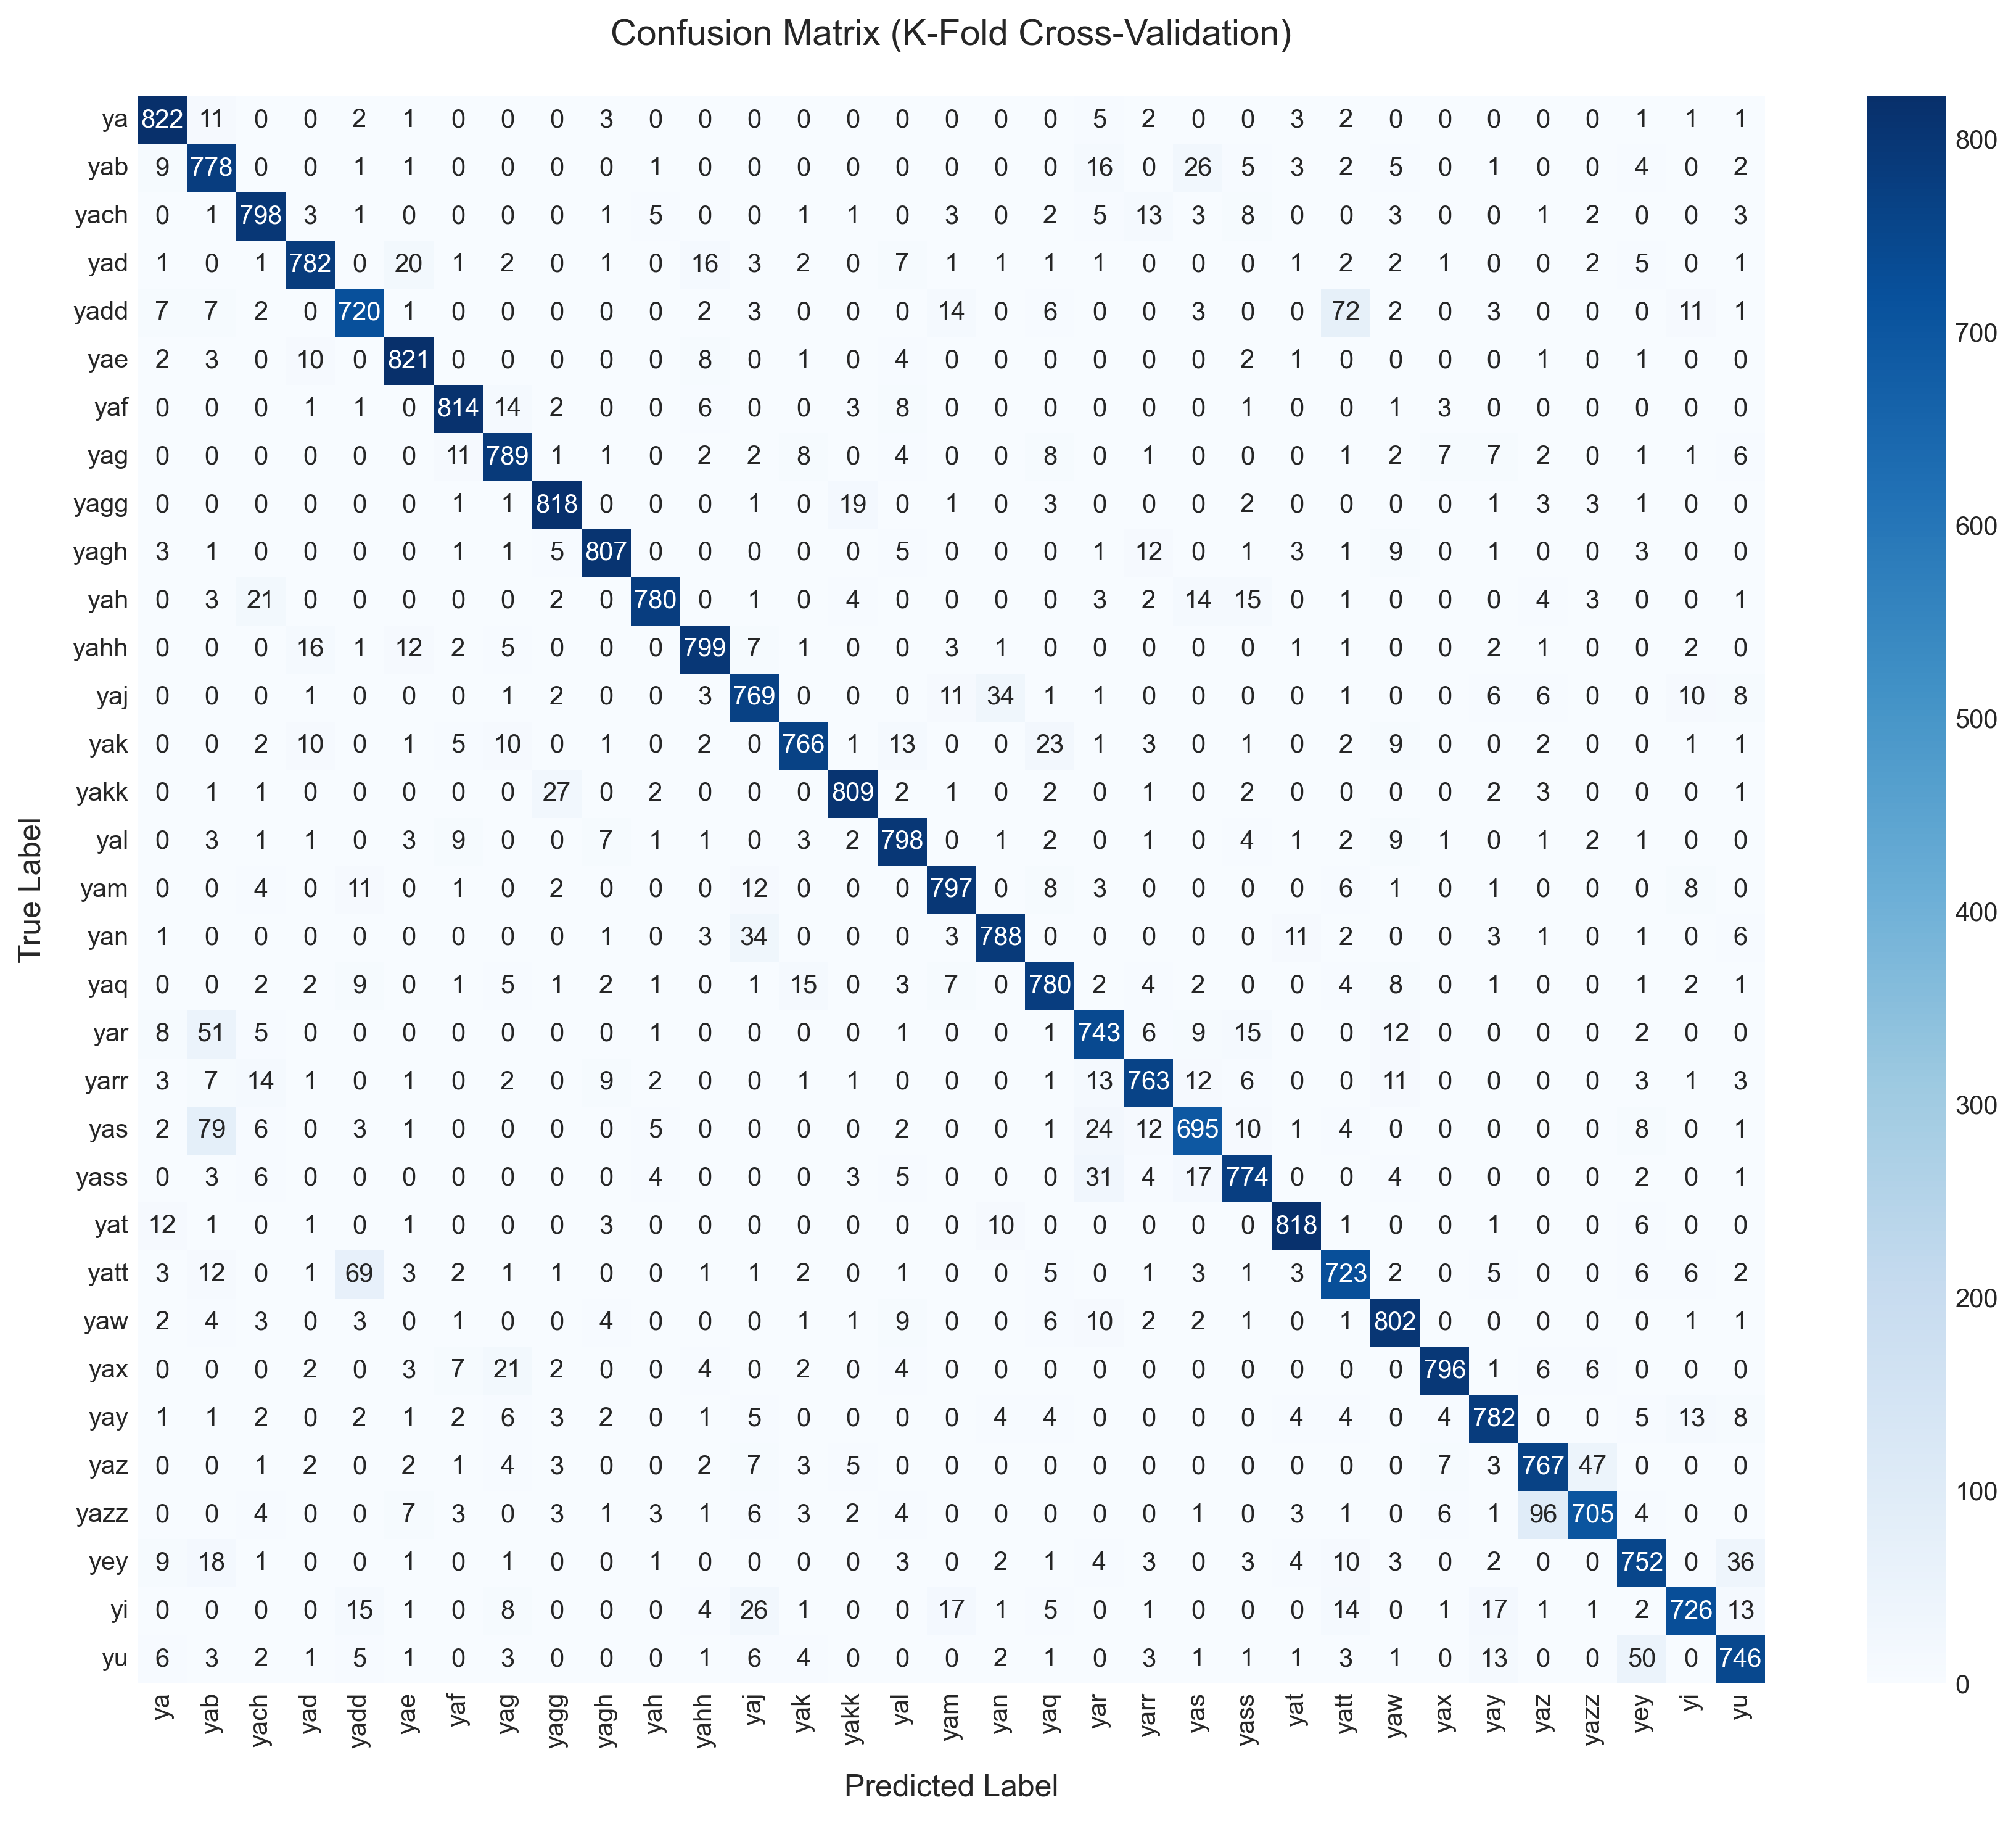

In [31]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.dpi'] = 300

# Compute confusion matrix
cm = confusion_matrix(all_test_labels, all_test_predictions)

# Create figure
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            annot_kws={"size": 10})
plt.title('Confusion Matrix (K-Fold Cross-Validation)', pad=20)
plt.xlabel('Predicted Label', labelpad=10)
plt.ylabel('True Label', labelpad=10)
plt.tight_layout()

# Save as high-quality PNG
plt.savefig('confusion_matrix_kfold_high_quality.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Loss and accuracy curves: 

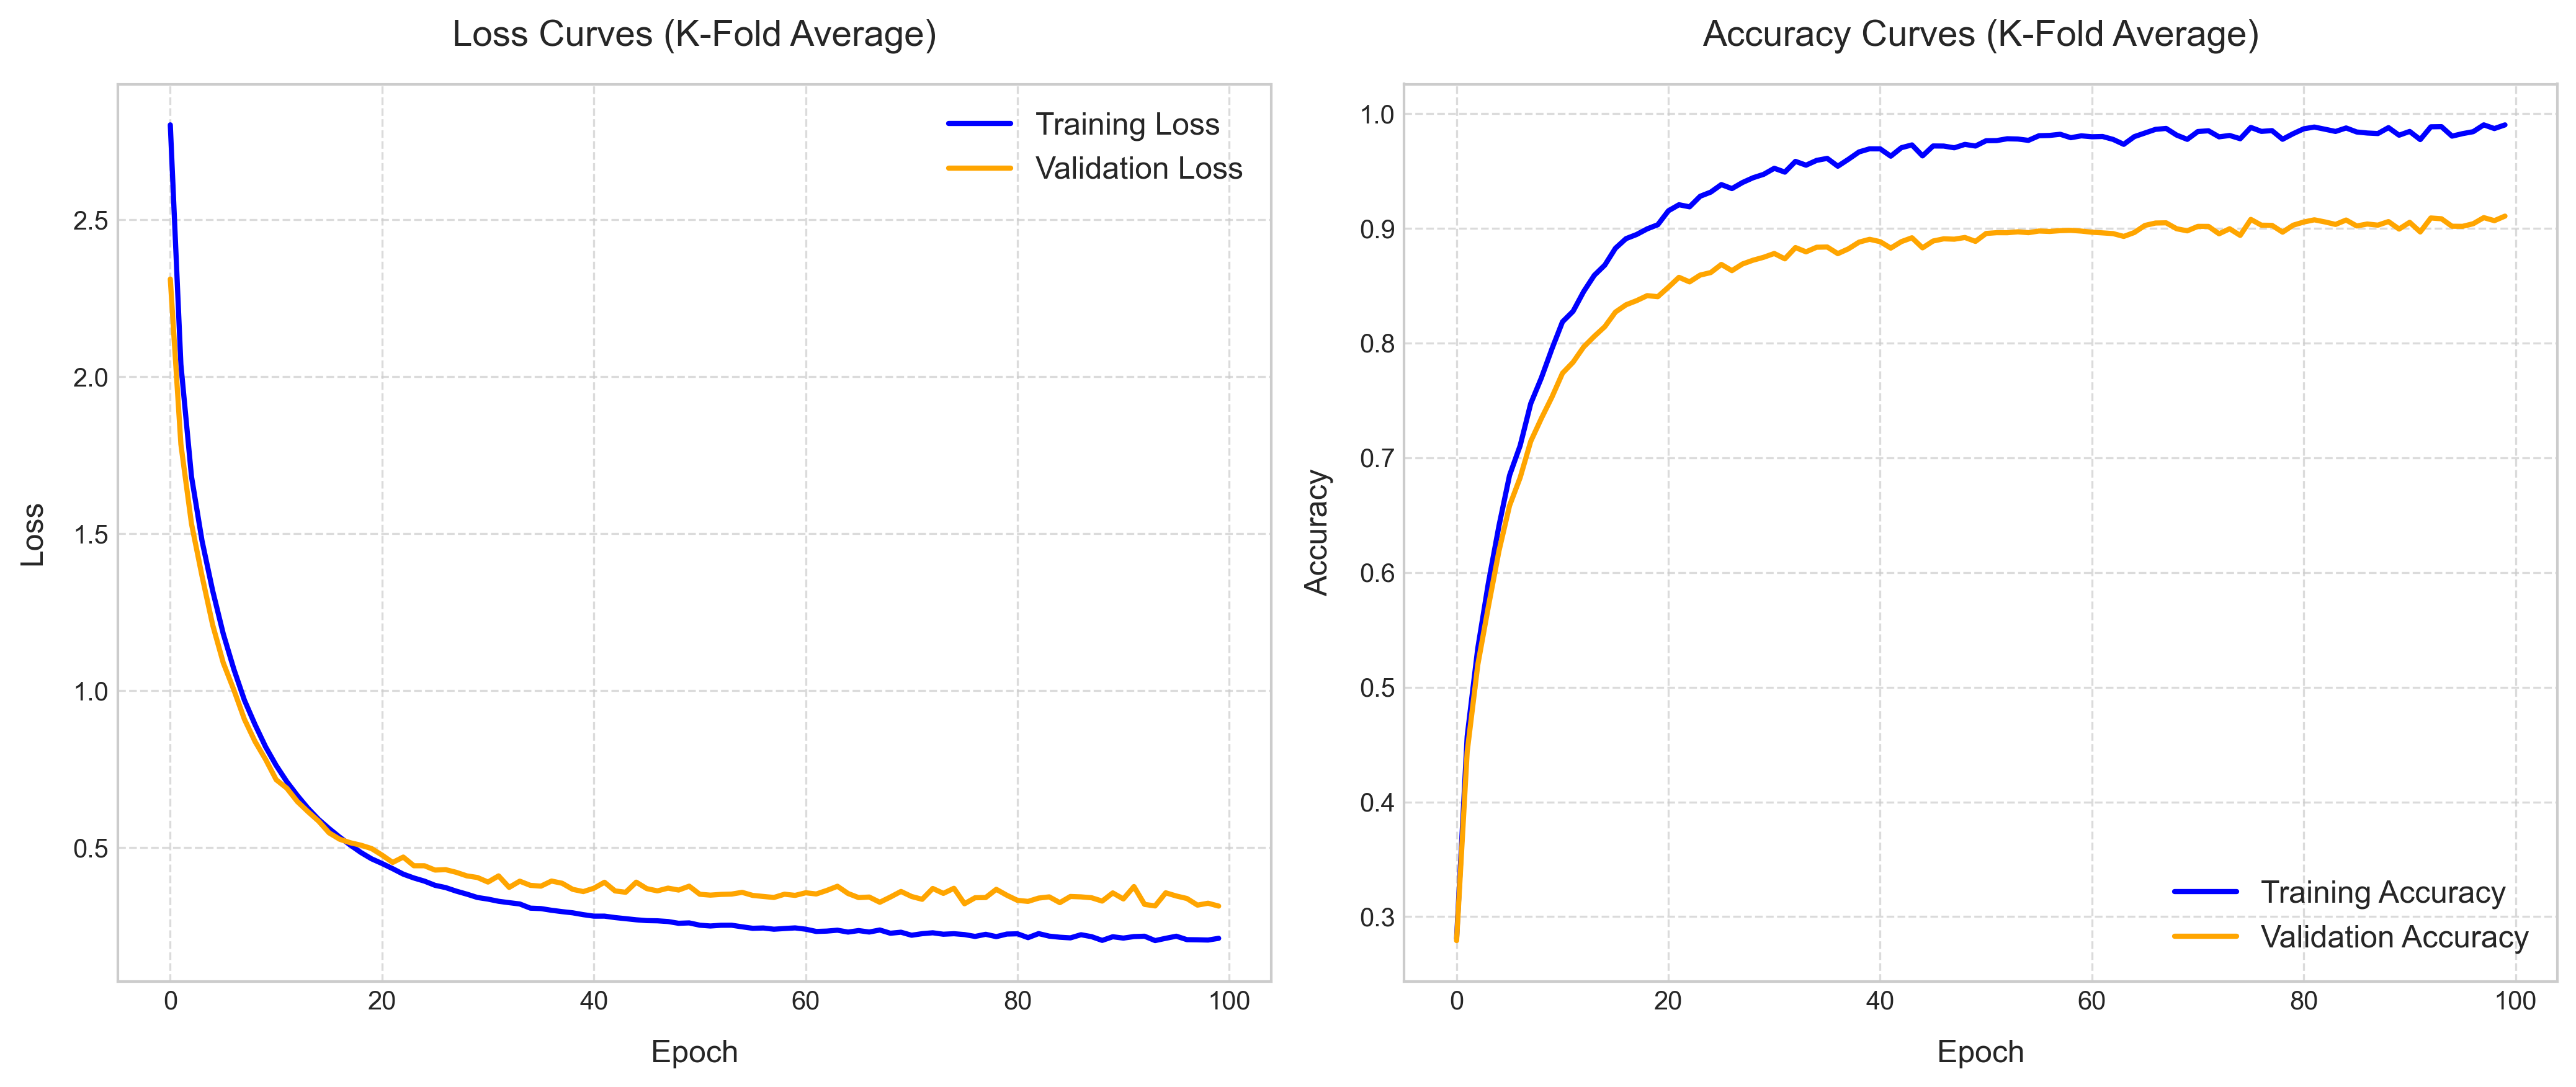

In [36]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss curves
ax1.plot(mean_train_losses, label='Training Loss', color='blue', linewidth=2)
ax1.plot(mean_val_losses, label='Validation Loss', color='orange', linewidth=2)
ax1.set_title('Loss Curves (K-Fold Average)', pad=15)
ax1.set_xlabel('Epoch', labelpad=10)
ax1.set_ylabel('Loss', labelpad=10)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot accuracy curves
ax2.plot(mean_train_accuracies, label='Training Accuracy', color='blue', linewidth=2)
ax2.plot(mean_val_accuracies, label='Validation Accuracy', color='orange', linewidth=2)
ax2.set_title('Accuracy Curves (K-Fold Average)', pad=15)
ax2.set_xlabel('Epoch', labelpad=10)
ax2.set_ylabel('Accuracy', labelpad=10)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and save
plt.tight_layout()
plt.savefig('loss_accuracy_plot_kfold_high_quality.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()